In [6]:
from types import FunctionType

import cv2
import numpy as np

from PIL import Image as PImage

from additonFunc import create_image_plot

## Методы для поворота изображения

In [78]:
"""
    Класс содержащий разные методы для поворта изображения
"""
class RotationMethods():

    __target_prefix = "_RotationMethods__rotate_"

    def get_method(self, method_name):
        methods = {key.removeprefix(self.__target_prefix):val for key, val in RotationMethods.__dict__.items() if key.startswith(self.__target_prefix)}
        target_method = methods.get(method_name, None)
        if target_method is None:
            raise AttributeError(f"Not found methods with name: '{method_name}'\n\tAvailable methods: {list(methods.keys())}")
        return target_method

    @staticmethod
    def __rotate_PIL(image, angle):
        i = PImage.fromarray(image)
        return np.array(i.rotate(angle, expand=True))

    @staticmethod
    def __rotate_rotMatrix(image, angle, scale = 1.0):
        (h, w) = image.shape[:2]
        center = (w//2, h//2)

        rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

        rotated_img = cv2.warpAffine(image, rotation_matrix, (w, h))

        return rotated_img
        
    @staticmethod
    def __rotate_manualImpl_1(image, angle):
        (h, w) = image.shape[:2]
        angle = 360-angle

        angle_rad = np.deg2rad(angle)
        sin = np.sin(angle_rad)
        cos = np.cos(angle_rad)
        
        new_w = int(abs(h * sin) + abs(w * cos))
        new_h = int(abs(h * cos) + abs(w * sin))

        rotated_img = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

        center = (w//2, h//2)
        new_center = (new_w // 2, new_h // 2)

        for i in range(new_h):
            for j in range(new_w):
                new_x = j - new_center[0]
                new_y = i - new_center[1]

                x = int(new_x * cos + new_y * sin)
                y = int(-new_x * sin + new_y * cos)

                x += center[0]
                y += center[1]

                if 0 <= x < w and 0 <= y < h:
                    rotated_img[i, j] = image[y, x]
        return rotated_img
    
    @staticmethod
    def __rotate_manualImpl_1vec1(image, angle):
        (h, w) = image.shape[:2]
        angle = np.deg2rad(360 - angle)

        sin = np.sin(angle)
        cos = np.cos(angle)

        new_w = int(abs(h * sin) + abs(w * cos))
        new_h = int(abs(h * cos) + abs(w * sin))

        rotated_img = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

        center = np.array([w // 2, h // 2])
        new_center = np.array([new_w // 2, new_h // 2])

        new_x, new_y = np.meshgrid(np.arange(new_w), np.arange(new_h))
        new_x = new_x - new_center[0]
        new_y = new_y - new_center[1]

        x = np.round(new_x * cos + new_y * sin).astype(int)
        y = np.round(-new_x * sin + new_y * cos).astype(int)

        x += center[0]
        y += center[1]

        valid_indices = np.logical_and.reduce((x >= 0, x < w, y >= 0, y < h))
        rotated_img[new_y[valid_indices] + new_center[1], new_x[valid_indices] + new_center[0]] = image[y[valid_indices], x[valid_indices]]

        return rotated_img
        
    @staticmethod
    def __rotate_manualImpl_1vec2fix(image, angle):
        rotated = RotationMethods.__rotate_manualImpl_1vec1(image, angle)

        (h, w) = image.shape[:2]
        (h_n, w_n) = rotated.shape[:2]

        h_shift = abs(h_n - h) // 2
        w_shift = abs(w_n - w) // 2
        coeff_1 = 1 if h_n-h_shift - h_shift != h else 0
        coeff_2 = 1 if w_n-w_shift - w_shift != w else 0
        rotated_cropped = rotated[h_shift:h_n-h_shift-1, w_shift:w_n-w_shift-1]
        return rotated_cropped

    @staticmethod
    def __rotate_manualImpl_1vec2(image, angle):
        (h, w) = image.shape[:2]
        angle = np.deg2rad(360 - angle)

        sin = np.sin(angle)
        cos = np.cos(angle)

        new_w = int(abs(h * sin) + abs(w * cos))
        new_h = int(abs(h * cos) + abs(w * sin))

        rotated_img = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

        center = np.array([w // 2, h // 2])
        new_center = np.array([new_w // 2, new_h // 2])

        new_x = np.arange(new_w) - new_center[0]
        new_y = np.arange(new_h) - new_center[1]
        new_x = new_x[:, np.newaxis]
        new_y = new_y[np.newaxis, :]

        x = np.round(new_x * cos + new_y * sin).astype(int)
        y = np.round(-new_x * sin + new_y * cos).astype(int)

        x += center[0]
        y += center[1]

        valid_indices = np.logical_and.reduce((x >= 0, x < w, y >= 0, y < h))
        valid_indices_2d = np.nonzero(valid_indices)

        valid_x = x[valid_indices]
        valid_y = y[valid_indices]
        valid_rotated_x = valid_indices_2d[1] + new_center[0]
        valid_rotated_y = valid_indices_2d[0] + new_center[1]

        mask = np.logical_and.reduce((valid_rotated_x >= 0, valid_rotated_x < new_w, valid_rotated_y >= 0, valid_rotated_y < new_h))
        valid_rotated_x = valid_rotated_x[mask]
        valid_rotated_y = valid_rotated_y[mask]
        valid_x = valid_x[mask]
        valid_y = valid_y[mask]

        rotated_img[valid_rotated_y, valid_rotated_x] = image[valid_y, valid_x]
        return rotated_img


    @staticmethod
    def __rotate_manualImpl_2(image, angle):
        (h, w) = image.shape[:2]

        angle_rad = np.deg2rad(angle)
        sin = np.sin(angle_rad)
        cos = np.cos(angle_rad)
        
        new_w = int(abs(h * sin) + abs(w * cos))
        new_h = int(abs(h * cos) + abs(w * sin))

        rotated_img = np.zeros((new_h, new_w, image.shape[2]), dtype=np.uint8)

        center = (w//2, h//2)
        new_center = (new_w // 2, new_h // 2)

        for i in range(h):
            for j in range(w):
                x = j-center[0]
                y = i-center[1]

                new_x = x * cos + y * sin
                new_y = -x * sin + y * cos

                new_x = int(new_center[0] + new_x)
                new_y = int(new_center[1] + new_y)

                if 0 <= new_x < new_w and 0 <= new_y < new_h:
                    rotated_img[new_y, new_x] = image[i,j]

        return rotated_img



## Основной класс аугментации

In [79]:
class ImageRotater():

    def __init__(self, mode : str = 'PIL', angle = None):
        self.mode = mode
        self.angle = angle
        self.rotation_func = RotationMethods().get_method(mode)
        
    def __call__(self, image, angle = None, **kwargs):
        if self.angle is not None:
            angle = self.angle
        return self.rotation_func(image, angle, **kwargs)

    def forward(self, image, angle = None, **kwargs):
        if self.angle is not None:
            angle = self.angle
        return self(image, angle, **kwargs)
    
    def apply(self, image, angle = None, **kwargs):
        if self.angle is not None:
            angle = self.angle
        return self(image, angle, **kwargs)
    

In [80]:
import matplotlib.pyplot as plt

In [81]:
angle = 35

im = cv2.imread('gus.jpg')


In [82]:
%%timeit

a = ImageRotater("manualImpl_1vec2fix")

print(a(im, angle).shape, im.shape)

(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200, 3) (800, 1200, 3)
(800, 1200

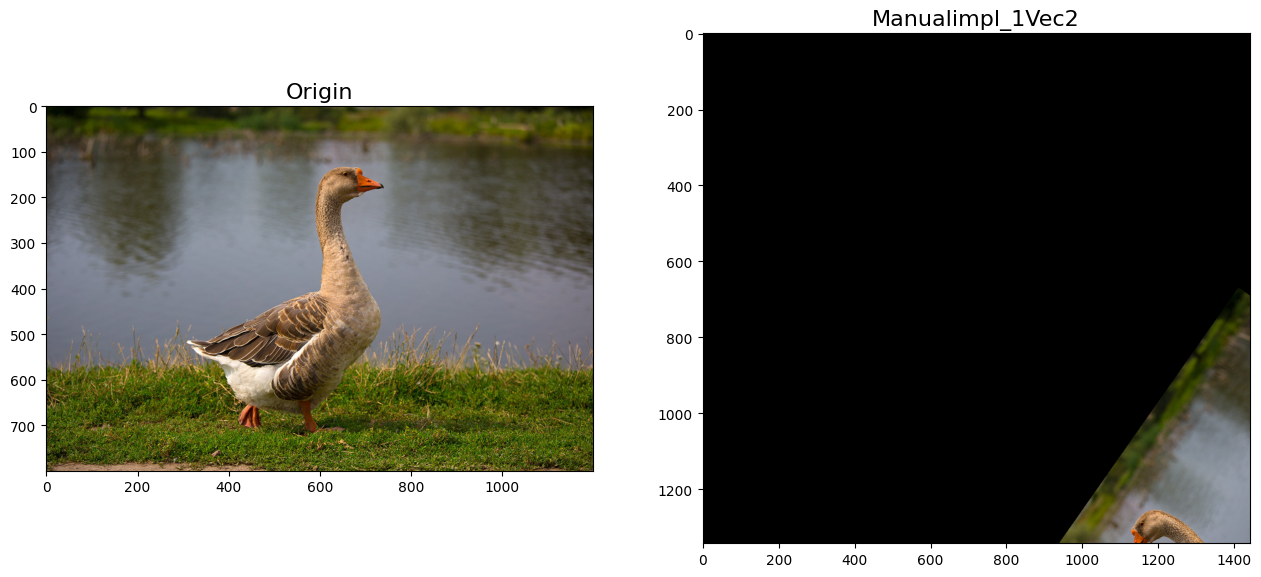

In [75]:
rotations = [
    # ImageRotater(),
    # ImageRotater("rotMatrix"),
    # ImageRotater("manualImpl_1"),
    ImageRotater("manualImpl_1vec2"),
]


to_show = {
    "origin": im
}

for rot in rotations:
    to_show.update({rot.mode:rot(im, angle)})

fig = create_image_plot(row_len=3, figsize=(24, 16), **to_show)